In [1]:
import csv
from collections import defaultdict
from collections import namedtuple
from functools import partial
from itertools import product
from pathlib import Path
from typing import TypedDict

import torch
import seaborn as sns
from torch import nn
from torch.utils.data.dataloader import DataLoader
from torchvision import models as tv_models
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [2]:
BATCH_SIZE = 100
LR = 0.001
OUT_FILEPATH = Path("./results.csv")
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

# Output file settings
ERASE_RESULTS = True
FIELDS = ["model_desc", "accuracy",]


class Row(TypedDict):
    model_desc: str
    accuracy: float


torch.manual_seed(42);

In [3]:
def one_hot(class_: int) -> torch.Tensor:
    vec = torch.zeros(10, dtype=torch.float32)
    vec[class_] = 1.0

    return vec

In [4]:
dataset_factory = partial(CIFAR10, root="./data", download=True, target_transform=one_hot)
train_dataset_factory = partial(dataset_factory, train=True)
test_dataset_factory = partial(dataset_factory, train=False)
dataloader_factory = partial(DataLoader, batch_size=BATCH_SIZE)

In [5]:
# Create/erase output file for results
if ERASE_RESULTS:
    with open(OUT_FILEPATH, 'w', newline='') as out:
        csv_writer = csv.DictWriter(out, FIELDS)

        # Write data from previous practice
        csv_writer.writerow(Row(
            model_desc='ResNet18\n Special for CIFAR10',
            accuracy=0.91,
        ))

    del out

In [6]:
def classifier(in_features, deep=False, num_classes=10):
    if not deep:
        return nn.Linear(in_features, num_classes)

    hidden_size = 100

    return nn.Sequential(
        nn.Linear(in_features, hidden_size),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_size, num_classes),
    )

In [7]:
def get_correct(predictions, ground_truth) -> int:
    with torch.no_grad():
        correct = (
            (predictions.argmax(dim=1) == ground_truth.argmax(dim=1))
            .cpu()
            .detach()
            .to(torch.int32)
            .sum()
            .item()
        )

    return correct

In [8]:
def train_model(model, dataloader, criterion, optimizer, num_epochs) -> float:
    model = model.to(DEVICE)
    model.train()
    accuracy = 0

    for epoch_no in range(1, num_epochs + 1):
        running_loss = 0
        train_mean_loss = 0
        correct = 0
        total = 0

        for signals, ground_truth in tqdm(
            dataloader,
            desc='Train batches',
            total=len(dataloader),
        ):
            optimizer.zero_grad()

            signals = signals.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)

            predictions = model(signals)
            loss_value = criterion(predictions, ground_truth)
            loss_value.backward()

            optimizer.step()

            correct += get_correct(predictions, ground_truth)
            total += len(predictions)
            mean_loss = torch.mean(loss_value.cpu().detach()).item()
            running_loss += mean_loss

            train_mean_loss = running_loss / len(dataloader)

        accuracy = correct / total

        print(
            f'Epoch: {epoch_no:02d} '
            f'| train loss: {train_mean_loss:.4f} '
            f'| accuracy: {accuracy:.4f}\n'
        )

    return accuracy


def test_model(model, dataloader) -> float:
    model = model.to(DEVICE)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data, ground_truth in tqdm(
            dataloader,
            desc='Test batches',
            total=len(dataloader),
        ):
            data = data.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)

            predictions = model(data)
            correct += get_correct(predictions, ground_truth)
            total += len(predictions)

    return correct / total

In [9]:
Pretrained = namedtuple('Pretrained', ['model', 'weights', 'name', 'out_features'])

# Each model has either 'fc' nor 'classifier' linear layer attribute
pretrained = [
    Pretrained(tv_models.vit_b_32, tv_models.ViT_B_32_Weights.DEFAULT, 'Vision Transformer B32', 768),
    Pretrained(tv_models.mobilenet_v3_small, tv_models.MobileNet_V3_Small_Weights.DEFAULT, 'MobileNetV3 S', 576),
    Pretrained(tv_models.mnasnet0_75, tv_models.MNASNet0_75_Weights.DEFAULT, 'MNASNet 0.5', 1280),
    Pretrained(tv_models.resnet18, tv_models.ResNet18_Weights.DEFAULT, 'ResNet18', 512),
]

In [10]:
Config = namedtuple('Config', ['deep', 'num_epochs'])

configs = [
    Config(deep=False, num_epochs=4),
    Config(deep=True, num_epochs=6),
]

In [11]:
best_model = ""
best_accuracy = 0

for (pretrained_model, weights, model_name, out_features), config in product(pretrained, configs):
    transform = weights.transforms()

    train_dataloader = dataloader_factory(train_dataset_factory(transform=transform))
    test_dataloader = dataloader_factory(test_dataset_factory(transform=transform))

    model = pretrained_model(weights=weights)

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Add new classifier
    classifier_placeholder = classifier(out_features, deep=config.deep)

    if hasattr(model, 'fc'):
        model.fc = classifier_placeholder
    elif hasattr(model, 'classifier'):
        model.classifier = classifier_placeholder
    elif hasattr(model, 'heads'):
        model.heads = classifier_placeholder
    else:
        raise RuntimeError("Model does not have known out layers")

    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(
        (
            getattr(model, 'fc', None)
            or getattr(model, 'classifier', None)
            or getattr(model, 'heads')
        ).parameters(),
        LR,
    )

    print(model)

    __ = train_model(model, train_dataloader, criterion, optimizer, config.num_epochs)
    test_accuracy = test_model(model, test_dataloader)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = (
            str(model)
            + f'\nClassifier: {"deep" if config.deep else "simple"}'
            + f'\nNum epochs: {config.num_epochs}'
            + f'\nTest accuracy: {test_accuracy}'
        )

    print(f'Test accuracy: {test_accuracy:.4f}')

    with open(OUT_FILEPATH, 'a', newline='') as out:
        csv_writer = csv.DictWriter(out, FIELDS)
        addon = '\nDeep classifier' if config.deep else ''

        csv_writer.writerow(Row(
            model_desc=model_name + addon + f'\n{config.num_epochs} epochs',
            accuracy=test_accuracy,
        ))

del best_accuracy

Files already downloaded and verified
Files already downloaded and verified
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (

Train batches: 100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


Epoch: 01 | train loss: 0.2891 | accuracy: 0.9159



Train batches: 100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


Epoch: 02 | train loss: 0.1727 | accuracy: 0.9442



Train batches: 100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


Epoch: 03 | train loss: 0.1529 | accuracy: 0.9503



Train batches: 100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


Epoch: 04 | train loss: 0.1411 | accuracy: 0.9537



Test batches: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


Test accuracy: 0.9411
Files already downloaded and verified
Files already downloaded and verified
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): E

Train batches: 100%|██████████| 500/500 [01:45<00:00,  4.72it/s]


Epoch: 01 | train loss: 0.2668 | accuracy: 0.9182



Train batches: 100%|██████████| 500/500 [01:46<00:00,  4.71it/s]


Epoch: 02 | train loss: 0.1655 | accuracy: 0.9449



Train batches: 100%|██████████| 500/500 [01:46<00:00,  4.70it/s]


Epoch: 03 | train loss: 0.1397 | accuracy: 0.9532



Train batches: 100%|██████████| 500/500 [01:45<00:00,  4.72it/s]


Epoch: 04 | train loss: 0.1208 | accuracy: 0.9593



Train batches: 100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


Epoch: 05 | train loss: 0.1056 | accuracy: 0.9639



Train batches: 100%|██████████| 500/500 [01:45<00:00,  4.74it/s]


Epoch: 06 | train loss: 0.0909 | accuracy: 0.9691



Test batches: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Test accuracy: 0.9439
Files already downloaded and verified
Files already downloaded and verified
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid

Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Epoch: 01 | train loss: 0.9468 | accuracy: 0.7199



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch: 02 | train loss: 0.6320 | accuracy: 0.7895



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


Epoch: 03 | train loss: 0.5742 | accuracy: 0.8046



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Epoch: 04 | train loss: 0.5432 | accuracy: 0.8149



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Test accuracy: 0.8148
Files already downloaded and verified
Files already downloaded and verified
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid

Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 01 | train loss: 0.8456 | accuracy: 0.7198



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Epoch: 02 | train loss: 0.6011 | accuracy: 0.7911



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch: 03 | train loss: 0.5497 | accuracy: 0.8094



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


Epoch: 04 | train loss: 0.5189 | accuracy: 0.8206



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch: 05 | train loss: 0.4981 | accuracy: 0.8274



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch: 06 | train loss: 0.4777 | accuracy: 0.8321



Test batches: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Test accuracy: 0.8362
Files already downloaded and verified
Files already downloaded and verified
MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, a

Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.86it/s]


Epoch: 01 | train loss: 0.9796 | accuracy: 0.6997



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch: 02 | train loss: 0.7042 | accuracy: 0.7628



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Epoch: 03 | train loss: 0.6499 | accuracy: 0.7791



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch: 04 | train loss: 0.6191 | accuracy: 0.7889



Test batches: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Test accuracy: 0.6551
Files already downloaded and verified
Files already downloaded and verified
MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, a

Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


Epoch: 01 | train loss: 0.9186 | accuracy: 0.6915



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


Epoch: 02 | train loss: 0.6880 | accuracy: 0.7618



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


Epoch: 03 | train loss: 0.6291 | accuracy: 0.7816



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Epoch: 04 | train loss: 0.5914 | accuracy: 0.7934



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Epoch: 05 | train loss: 0.5572 | accuracy: 0.8064



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]


Epoch: 06 | train loss: 0.5265 | accuracy: 0.8162



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Test accuracy: 0.6382
Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, e

Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


Epoch: 01 | train loss: 0.9486 | accuracy: 0.6936



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


Epoch: 02 | train loss: 0.6945 | accuracy: 0.7619



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


Epoch: 03 | train loss: 0.6580 | accuracy: 0.7726



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.68it/s]


Epoch: 04 | train loss: 0.6398 | accuracy: 0.7780



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Test accuracy: 0.7690
Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, e

Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


Epoch: 01 | train loss: 0.9367 | accuracy: 0.6830



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


Epoch: 02 | train loss: 0.7271 | accuracy: 0.7493



Train batches: 100%|██████████| 500/500 [01:13<00:00,  6.77it/s]


Epoch: 03 | train loss: 0.6888 | accuracy: 0.7608



Train batches: 100%|██████████| 500/500 [01:13<00:00,  6.78it/s]


Epoch: 04 | train loss: 0.6648 | accuracy: 0.7682



Train batches: 100%|██████████| 500/500 [01:13<00:00,  6.79it/s]


Epoch: 05 | train loss: 0.6470 | accuracy: 0.7746



Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch: 06 | train loss: 0.6304 | accuracy: 0.7813



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]

Test accuracy: 0.7772


In [12]:
print(best_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [13]:
data = defaultdict(list)

with open(OUT_FILEPATH, 'r') as in_:
    csv_reader = csv.DictReader(in_, FIELDS)

    for row in csv_reader:
        for key, value in row.items():
            if key == 'accuracy':
                value = float(value)

            data[key].append(value)

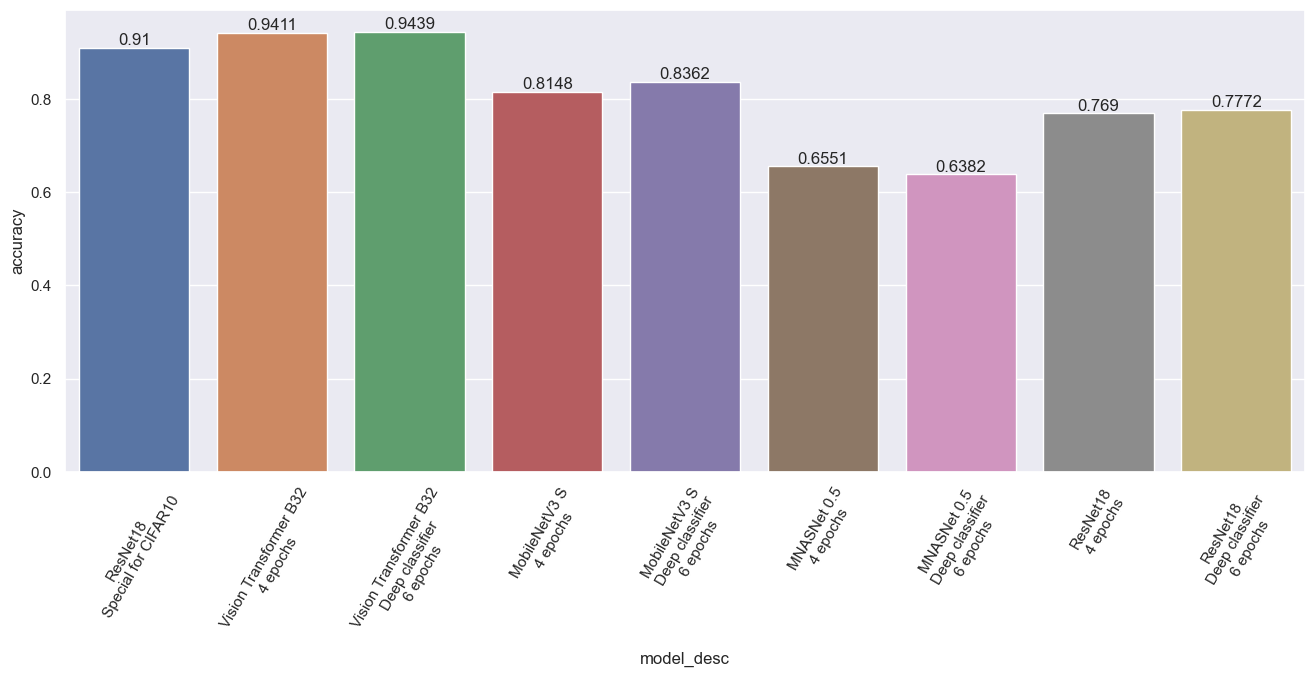

In [14]:
sns.set(rc={'figure.figsize': (16, 6)})

g = sns.barplot(data=data, x='model_desc', y='accuracy', hue="model_desc")
for item in g.get_xticklabels():
    item.set_rotation(60)

for i in g.containers:
    g.bar_label(i)  # type: ignore